In [26]:
%load_ext autoreload
%autoreload 2
import os
import scipy
import numpy as np
import scipy.io
import pandas as pd
import time
import Util
import matplotlib.pyplot as plt
from multiprocessing import Pool

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# This is with simulated data just to test matlab nonsense

In [2]:
#To generate fake data
ogcwd = os.getcwd()
os.chdir('./matlab/sim_data')
for i in range(2):
    mdict = {'S': np.eye(3) + np.random.random((3,3)) * 0.1}
    scipy.io.savemat('testS{}.mat'.format(i), mdict)
os.chdir(ogcwd)

In [3]:
c1 = Util.construct_command('testS0.mat', 'testOut0.mat', 'sim_data')
c2 = Util.construct_command('testS1.mat', 'testOut1.mat', 'sim_data')

In [4]:
string = "matlab -nodisplay -nodesktop -r \"{}; {}; exit;\"".format(c1, c2)

In [5]:
string

'matlab -nodisplay -nodesktop -r "computecov \'./sim_data/testS0.mat\' \'./sim_data/testOut0.mat\'; computecov \'./sim_data/testS1.mat\' \'./sim_data/testOut1.mat\'; exit;"'

In [6]:
Util.construct_string_commands([c1,c2])

'matlab -nodisplay -nodesktop -r "computecov \'./sim_data/testS0.mat\' \'./sim_data/testOut0.mat\'; computecov \'./sim_data/testS1.mat\' \'./sim_data/testOut1.mat\'; exit;"'

In [7]:
ogcwd = os.getcwd()
os.chdir('./matlab')
os.system(string)
os.chdir(ogcwd)

In [9]:
for i in range(2):
    fname = Util.format_appro('testOut{}'.format(i), data_folder = 'matlab/sim_data')
    Sigma = scipy.io.loadmat(fname)['Sigma']
    print(Sigma)

[[1.07236762 0.06850456 0.00765461]
 [0.06850456 1.05469713 0.03712618]
 [0.00765461 0.03712618 1.03764171]]
[[1.01864981 0.06924462 0.05395228]
 [0.06924462 1.05262125 0.08166481]
 [0.05395228 0.08166481 1.00944985]]


# This is with real financial data

In [4]:
ret, ret_nonan, univ, tradeidx, dates = Util.load_data()

In [10]:
N = 200 #Number of stocks
T = 100 #lookback (units of days)
P = 1 #lookahead

### First we populate the data folder the relevant sample covariance matrices

In [11]:
#Populates data folder with sample covariance matrix
ogcwd = os.getcwd()
os.chdir('./matlab/data')

for h in range(len(univ)):#len(univ)):
    pastRet = Util.get_past_period(h, T, N, univ, tradeidx, ret)
    S = np.cov(pastRet.T) #sample covariance
    mdict = {'S': S}
    scipy.io.savemat('N_{}_T_{}_unividx_{}.mat'.format(N, T, h), mdict)

os.chdir(ogcwd)

### Then we construct the commands to do the MTP2 estimation on the sample covariance matrices, and also run the command (takes around 7 seconds for all 360 samples)

In [18]:
all_commands = []
for h in range(len(univ)):
    c = Util.construct_command('N_{}_T_{}_unividx_{}.mat'.format(N, T, h), 
                          'out_N_{}_T_{}_unividx_{}.mat'.format(N, T, h))
    all_commands.append(c)

In [19]:
print(all_commands[:2])

["computecov './data/N_200_T_1260_unividx_0.mat' './data/out_N_200_T_1260_unividx_0.mat'", "computecov './data/N_200_T_1260_unividx_1.mat' './data/out_N_200_T_1260_unividx_1.mat'"]


In [21]:
string = Util.construct_string_commands(all_commands)

In [46]:
start = time.time()
ogcwd = os.getcwd()
os.chdir('./matlab')
os.system(string) #Have to make call within matlab folder, because that's where file is defined
os.chdir(ogcwd)
print(time.time() - start) #takes around 50 minutes (2518 seconds)

2518.566747188568


### Parallel version

In [23]:
cores = 8
commands = []
MTP2_cov_est = Util.MTP2_cov(N, T)
verbose = False
for i, arr in enumerate(np.array_split(range(len(univ)), cores)):
    all_commands = []
    for h in arr:
        try:
            MTP2_cov_est(h)
            if verbose:
                print("{} already present for {} {}".format(h, N, T))
        except:
            c = Util.construct_command('N_{}_T_{}_unividx_{}.mat'.format(N, T, h), 
                              'out_N_{}_T_{}_unividx_{}.mat'.format(N, T, h))
            all_commands.append(c)
    commands.append(Util.construct_string_commands(all_commands))

In [21]:
def matlab_command_wrapper(string):
    ogcwd = os.getcwd()
    os.chdir('./matlab')
    os.system(string) #Have to make call within matlab folder, because that's where file is defined
    os.chdir(ogcwd)

In [22]:
with Pool(cores) as p:
    p.map(matlab_command_wrapper, commands)

### Given the MTP2 estimates of the covariance matrix, loads them and calculates the out of sample variances

In [24]:
def get_OOS_rets(N, T, P, ret, univ, tradeidx, range_h = None):
    if not range_h:
        range_h = len(univ)
    
    MTP2_cov_est = Util.MTP2_cov(N,T)
    rets = []
    for h in range(range_h):
        cov = MTP2_cov_est(h)
        w = Util.optimal_weights(cov)
        outRet = Util.get_invest_period(h, P, N, univ, tradeidx, ret)
        curret = Util.retConstShare(outRet, w)
        rets.append(curret)
    return rets

In [25]:
MTP2_rets = get_OOS_rets(N, T, P, ret, univ, tradeidx, range_h = None)
Util.print_normalize(MTP2_rets)

0.10276108819046006 0.12094076278574159


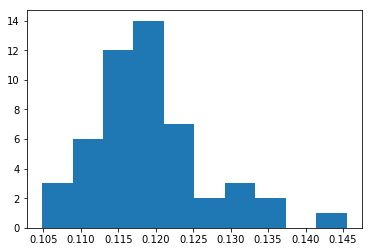

In [33]:
plt.hist(Util.subsample(MTP2_rets))
plt.show()